# 📚 **Table of Contents**
1. Project Introduction

2. Install & Import Libraries

3. Load Data

4. Data Understanding (Schema & Caveats)

5. Data Cleaning & Feature Engineering

6. Coordinate Conversion (UTM → Lat/Lon)

7. Exploratory Data Analysis (EDA)

8. Part 1 — Hotspot Detection (KMeans)

9. Hotspot Mapping & Cluster Profiling

10. Part 2 — Seasonal/Spatial Prediction

11. Explainability (SHAP for Tree Models)

12. Business Insights & Recommendations

13. Limitations, Ethics & Privacy Notes

# **1. Project Introduction**

**Title:** Crime Hotspot Detection & Seasonal Prediction in Vancouver

**Objective:**
This project uses Vancouver Police Department’s open crime dataset to:

1. Detect crime hotspots using clustering (KMeans) on spatial data.

2. Predict seasonal crime risks (likelihood of increase/decrease in different neighbourhoods).

3. Tell a business story about how it can help cities allocate police resources more effectively.

**Dataset:**

**Source:** https://geodash.vpd.ca/opendata/

**Contains:**

TYPE → Type of crime (e.g., Theft, Mischief, Break & Enter, Assault).

YEAR, MONTH, DAY, HOUR, MINUTE → When the incident occurred.

HUNDRED_BLOCK, NEIGHBOURHOOD → Generalized location (privacy-protected).

X, Y → Spatial coordinates (UTM Zone 10, convertible to lat/lon).

**Why This Project Stands Out:**
1. Most projects only plot crime counts on a map. This one goes further by:

2. Using unsupervised AI (KMeans) to find hidden crime clusters.

3. Building a predictive model to forecast seasonal changes.

4. Delivering business insights: e.g., “Downtown sees a 25% spike in vehicle theft during Winter.”

**Expected Outputs:**

   📊 Charts of crime trends.

   🗺️ Interactive hotspot maps.

   🤖 Predictions of seasonal crime risk.

   📑 Insights + recommendations for resource allocation.

# **2. Install & Import Libraries**

**What I’m going to do:**
Before working with the dataset, I’ll install and import all the Python libraries I’ll need for data analysis, clustering, machine learning, and visualization.

In [ ]:
# Install required libraries (quiet mode so output is clean)
!pip -q install pyproj folium scikit-learn xgboost shap

# Suppress warnings
import os, sys, warnings
warnings.filterwarnings("ignore")

# Core packages
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Mapping
import folium
from folium.plugins import MarkerCluster
from pyproj import Transformer

# ML & preprocessing
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.model_selection import train_test_split, TimeSeriesSplit
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor

# Explainability
import shap

# **3. Load Data**

I will load the Vancouver Police Department (VPD) crime dataset, check its shape, preview the first few rows, and confirm the available columns. This step ensures the dataset has been read correctly before we start analysis.

In [ ]:
# Load the dataset
file_path = "crimedata_csv_AllNeighbourhoods_2025.csv"
df = pd.read_csv(file_path)

# Check dataset structure
print("Shape of dataset:", df.shape)
print("Columns available:", df.columns.tolist())

# Preview first few records
df.head()


Shape of dataset: (19480, 10)
Columns available: ['TYPE', 'YEAR', 'MONTH', 'DAY', 'HOUR', 'MINUTE', 'HUNDRED_BLOCK', 'NEIGHBOURHOOD', 'X', 'Y']


TYPE  YEAR  MONTH  DAY  HOUR  MINUTE  \
0  Break and Enter Commercial  2025      1    4     3       4   
1  Break and Enter Commercial  2025      4    5    10      41   
2  Break and Enter Commercial  2025      5    4     9      12   
3  Break and Enter Commercial  2025      5   24     8      40   
4  Break and Enter Commercial  2025      7   10     9      19   

       HUNDRED_BLOCK NEIGHBOURHOOD            X             Y  
0  10XX BROUGHTON ST      West End  490247.1512  5.459171e+06  
1  10XX BROUGHTON ST      West End  490247.1512  5.459171e+06  
2  10XX BROUGHTON ST      West End  490247.1512  5.459171e+06  
3  10XX BROUGHTON ST      West End  490247.1512  5.459171e+06  
4  10XX BROUGHTON ST      West End  490247.4903  5.459171e+06

# **4. Data Understanding (Schema & Caveats)**

I will inspect the dataset in more detail to understand data types, missing values, and important schema notes. This helps confirm which features are ready for analysis and which need cleaning/engineering.

In [ ]:
# Dataset info (data types + null counts)
df.info()

# Quick statistics
df.describe(include='all').T

# Missing values check
df.isna().sum()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19480 entries, 0 to 19479
Data columns (total 10 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   TYPE           19480 non-null  object 
 1   YEAR           19480 non-null  int64  
 2   MONTH          19480 non-null  int64  
 3   DAY            19480 non-null  int64  
 4   HOUR           19480 non-null  int64  
 5   MINUTE         19480 non-null  int64  
 6   HUNDRED_BLOCK  19480 non-null  object 
 7   NEIGHBOURHOOD  19473 non-null  object 
 8   X              19480 non-null  float64
 9   Y              19480 non-null  float64
dtypes: float64(2), int64(5), object(3)
memory usage: 1.5+ MB


TYPE             0
YEAR             0
MONTH            0
DAY              0
HOUR             0
MINUTE           0
HUNDRED_BLOCK    0
NEIGHBOURHOOD    7
X                0
Y                0
dtype: int64

# **5. Data Cleaning & Feature Engineering**

Create a proper DATE column; add SEASON, DOW, MONTH_NAME; coerce dtypes; de‑duplicate; and print quick quality checks (nulls, uniques).

In [ ]:
# Ensure numeric dtypes where appropriate
for col in ["YEAR","MONTH","DAY","HOUR","MINUTE"]:
    if col in df.columns:
        df[col] = pd.to_numeric(df[col], errors="coerce")

# Build a datetime (fill missing time safely for privacy-masked rows)
dt_hour = df["HOUR"].fillna(12).clip(0,23).astype(int)
dt_min  = df["MINUTE"].fillna(0).clip(0,59).astype(int)
df["DATE"] = pd.to_datetime(dict(year=df["YEAR"], month=df["MONTH"], day=df["DAY"],
                                 hour=dt_hour, minute=dt_min), errors="coerce")

# Season feature
def month_to_season(m):
    return {12:"Winter",1:"Winter",2:"Winter",
            3:"Spring",4:"Spring",5:"Spring",
            6:"Summer",7:"Summer",8:"Summer",
            9:"Fall",10:"Fall",11:"Fall"}.get(int(m), None)

df["SEASON"] = df["MONTH"].map(month_to_season)

# Day-of-week and month-name
df["DOW"] = df["DATE"].dt.day_name()
df["MONTH_NAME"] = df["DATE"].dt.month_name()

# Categories
for c in ["TYPE","NEIGHBOURHOOD","SEASON","DOW","MONTH_NAME"]:
    if c in df.columns:
        df[c] = df[c].astype("category")

# Remove duplicates if any
df = df.drop_duplicates().reset_index(drop=True)

# Quality checks
print("Nulls per column:\n", df.isna().sum())
print("\nUnique TYPEs:", df["TYPE"].nunique(), "→", list(df["TYPE"].cat.categories)[:10], "...")
print("Unique NEIGHBOURHOODs:", df["NEIGHBOURHOOD"].nunique())
df.head(3)

Nulls per column:
 TYPE             0
YEAR             0
MONTH            0
DAY              0
HOUR             0
MINUTE           0
HUNDRED_BLOCK    0
NEIGHBOURHOOD    7
X                0
Y                0
DATE             0
SEASON           0
DOW              0
MONTH_NAME       0
dtype: int64

Unique TYPEs: 11 → ['Break and Enter Commercial', 'Break and Enter Residential/Other', 'Homicide', 'Mischief', 'Offence Against a Person', 'Other Theft', 'Theft from Vehicle', 'Theft of Bicycle', 'Theft of Vehicle', 'Vehicle Collision or Pedestrian Struck (with Fatality)'] ...
Unique NEIGHBOURHOODs: 24


TYPE  YEAR  MONTH  DAY  HOUR  MINUTE  \
0  Break and Enter Commercial  2025      1    4     3       4   
1  Break and Enter Commercial  2025      4    5    10      41   
2  Break and Enter Commercial  2025      5    4     9      12   

       HUNDRED_BLOCK NEIGHBOURHOOD            X             Y  \
0  10XX BROUGHTON ST      West End  490247.1512  5.459171e+06   
1  10XX BROUGHTON ST      West End  490247.1512  5.459171e+06   
2  10XX BROUGHTON ST      West End  490247.1512  5.459171e+06   

                 DATE  SEASON       DOW MONTH_NAME  
0 2025-01-04 03:04:00  Winter  Saturday    January  
1 2025-04-05 10:41:00  Spring  Saturday      April  
2 2025-05-04 09:12:00  Spring    Sunday        May

# **6. Coordinate Conversion (UTM → Lat/Lon)**

Convert UTM Zone 10 (X, Y) to WGS84 (LAT, LON) for mapping and clustering; keep only rows with valid coordinates for geo tasks.

In [ ]:
# UTM Zone 10N (EPSG:32610) -> WGS84 (EPSG:4326)
transformer = Transformer.from_crs("EPSG:32610", "EPSG:4326", always_xy=True)

def to_latlon(x, y):
    try:
        lon, lat = transformer.transform(x, y)
        return pd.Series([lat, lon])
    except Exception:
        return pd.Series([np.nan, np.nan])

latlon = df[["X","Y"]].apply(lambda r: to_latlon(r["X"], r["Y"]), axis=1)
latlon.columns = ["LAT","LON"]
df = pd.concat([df, latlon], axis=1)

# Subset with valid coordinates
df_geo = df.dropna(subset=["LAT","LON"]).copy()
print("Geo-enabled rows:", df_geo.shape[0], "out of", df.shape[0])
df_geo.head(3)

Geo-enabled rows: 18693 out of 18693


TYPE  YEAR  MONTH  DAY  HOUR  MINUTE  \
0  Break and Enter Commercial  2025      1    4     3       4   
1  Break and Enter Commercial  2025      4    5    10      41   
2  Break and Enter Commercial  2025      5    4     9      12   

       HUNDRED_BLOCK NEIGHBOURHOOD            X             Y  \
0  10XX BROUGHTON ST      West End  490247.1512  5.459171e+06   
1  10XX BROUGHTON ST      West End  490247.1512  5.459171e+06   
2  10XX BROUGHTON ST      West End  490247.1512  5.459171e+06   

                 DATE  SEASON       DOW MONTH_NAME        LAT         LON  
0 2025-01-04 03:04:00  Winter  Saturday    January  49.285213 -123.134108  
1 2025-04-05 10:41:00  Spring  Saturday      April  49.285213 -123.134108  
2 2025-05-04 09:12:00  Spring    Sunday        May  49.285213 -123.134108

# **7. Exploratory Data Analysis (EDA)**

Plot distributions by crime type, neighbourhood (top 15), season; and quick hour‑of‑day pattern. Produce a TYPE×SEASON matrix.

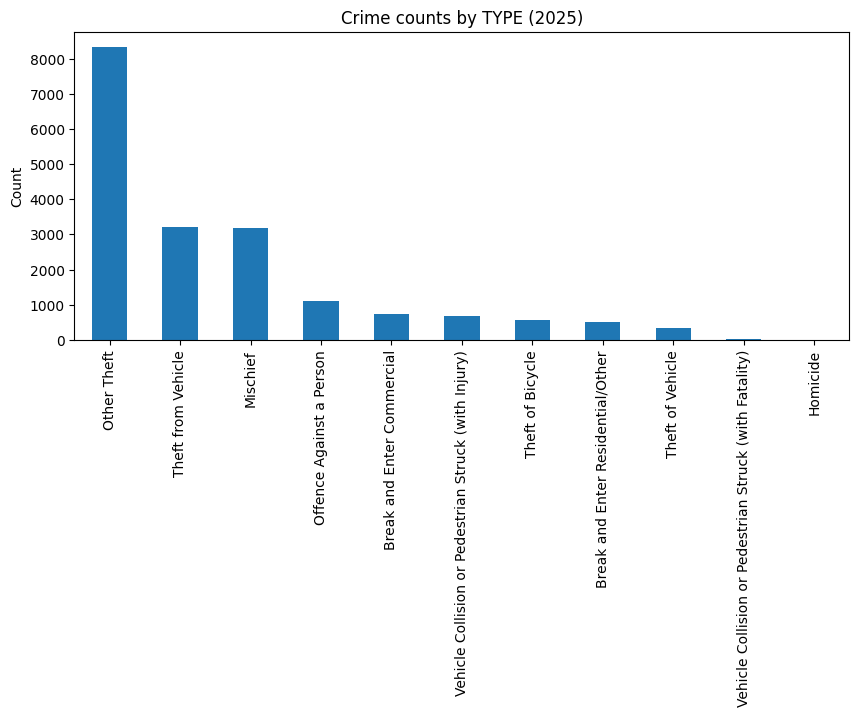

SEASON                                              Spring  Summer  Winter
TYPE                                                                      
Break and Enter Commercial                             330     206     211
Break and Enter Residential/Other                      181     183     147
Homicide                                                 6       2       0
Mischief                                              1378    1008     804
Offence Against a Person                               453     388     274
Other Theft                                           3386    2765    2193
Theft from Vehicle                                    1388    1043     767
Theft of Bicycle                                       198     280      74
Theft of Vehicle                                       132     129      78
Vehicle Collision or Pedestrian Struck (with Fa...       5       3       4
Vehicle Collision or Pedestrian Struck (with In...     275     221     181

In [ ]:
# Crime types
ax = df["TYPE"].value_counts().plot(kind="bar", figsize=(10,4))
ax.set_title("Crime counts by TYPE (2025)"); ax.set_ylabel("Count"); ax.set_xlabel("")
plt.show()

# Top neighbourhoods
df["NEIGHBOURHOOD"].value_counts().head(15).plot(kind="bar", figsize=(10,4), title="Top 15 neighbourhoods by incidents")
plt.ylabel("Count"); plt.xlabel("")
plt.show()

# TYPE x SEASON matrix
season_type = df.pivot_table(index="TYPE", columns="SEASON", values="YEAR", aggfunc="count", fill_value=0)
display(season_type.sort_index())

# Hourly pattern (if available)
if df["HOUR"].notna().sum() > 0:
    df["HOUR"].dropna().astype(int).value_counts().sort_index().plot(kind="bar", figsize=(10,4), title="Incidents by hour")
    plt.ylabel("Count"); plt.xlabel("Hour (24h)")
    plt.show()

# **8. Part 1 — Hotspot Detection (KMeans)**


I will standardize LAT/LON, evaluate only odd values of k (3,5,7,9,11,13,15) using the elbow (inertia) and silhouette score, automatically pick the best odd k by maximum silhouette, fit KMeans, and attach the cluster labels.

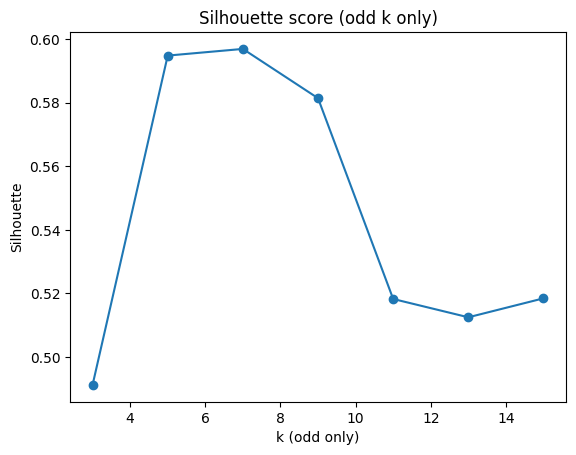

Selected BEST_K (odd only) = 7  |  silhouette = 0.597


CLUSTER
0    2296
1    1125
2     526
3    6244
4    1973
5    4277
6    2252
Name: count, dtype: int64

In [ ]:
# ---- Prepare features ----
X = df_geo[["LAT","LON"]].values
scaler = StandardScaler()
Xz = scaler.fit_transform(X)

# ---- Evaluate ONLY odd k ----
odd_K = list(range(3, 16, 2))  # 3,5,7,9,11,13,15
inertias = []
sil_scores = []

for k in odd_K:
    km = KMeans(n_clusters=k, random_state=42, n_init="auto").fit(Xz)
    inertias.append(km.inertia_)
    sil_scores.append(silhouette_score(Xz, km.labels_))

# ---- Plots (elbow + silhouette) ----
plt.plot(odd_K, inertias, marker="o")
plt.title("Elbow method (odd k only)")
plt.xlabel("k (odd only)")
plt.ylabel("Inertia")
plt.show()

plt.plot(odd_K, sil_scores, marker="o")
plt.title("Silhouette score (odd k only)")
plt.xlabel("k (odd only)")
plt.ylabel("Silhouette")
plt.show()

# ---- Choose best odd k by silhouette ----
BEST_K = odd_K[int(np.argmax(sil_scores))]
print(f"Selected BEST_K (odd only) = {BEST_K}  |  silhouette = {max(sil_scores):.3f}")

# ---- Final model & labels ----
kmeans = KMeans(n_clusters=BEST_K, random_state=42, n_init="auto")
df_geo["CLUSTER"] = kmeans.fit_predict(Xz)

# Quick check
df_geo["CLUSTER"].value_counts().sort_index()

# **9. Hotspot Mapping & Cluster Profiling**


I will create an interactive Folium map with crime incidents colored by their cluster assignment. Then, I’ll profile clusters by showing the top crime types and top neighbourhoods in each cluster. This helps us understand what each hotspot represents.

In [ ]:
# ---- Initialize map centered on Vancouver ----
m = folium.Map(location=[49.2827, -123.1207], zoom_start=12, tiles="cartodbpositron")

# ---- Colors for clusters ----
palette = ["red","blue","green","purple","orange","darkred",
           "lightblue","lightgreen","cadetblue","pink","gray","beige"]
cmap = {c: palette[c % len(palette)] for c in range(df_geo["CLUSTER"].nunique())}

# ---- Sample subset for performance ----
plot_df = df_geo.sample(min(len(df_geo), 5000), random_state=42)

for _, r in plot_df.iterrows():
    folium.CircleMarker(
        location=[r["LAT"], r["LON"]],
        radius=2,
        color=cmap[r["CLUSTER"]],
        fill=True,
        fill_opacity=0.6,
        popup=f'Cluster {int(r["CLUSTER"])} | {r["TYPE"]} | {r["NEIGHBOURHOOD"]}'
    ).add_to(m)

m  # Renders interactive map in Colab

In [ ]:
# ---- Cluster profiling ----

# Top crime types per cluster
prof_type = (df_geo.groupby(["CLUSTER","TYPE"])
             .size().reset_index(name="COUNT")
             .sort_values(["CLUSTER","COUNT"], ascending=[True, False])
             .groupby("CLUSTER").head(3))
print("Top crime types per cluster:")
display(prof_type)

# Top neighbourhoods per cluster
prof_neigh = (df_geo.groupby(["CLUSTER","NEIGHBOURHOOD"])
              .size().reset_index(name="COUNT")
              .sort_values(["CLUSTER","COUNT"], ascending=[True, False])
              .groupby("CLUSTER").head(3))
print("Top neighbourhoods per cluster:")
display(prof_neigh)

Top crime types per cluster:


CLUSTER                                               TYPE  COUNT
5         0                                        Other Theft    843
3         0                                           Mischief    508
6         0                                 Theft from Vehicle    462
15        1                           Offence Against a Person   1115
13        1                                           Homicide      8
21        1  Vehicle Collision or Pedestrian Struck (with I...      2
27        2                                        Other Theft    168
28        2                                 Theft from Vehicle    139
25        2                                           Mischief     95
38        3                                        Other Theft   3233
36        3                                           Mischief   1158
39        3                                 Theft from Vehicle   1146
49        4                                        Other Theft   1236
50        4                                 Theft from Vehicle    226
47        4                                           Mischief    217
60        5                                        Other Theft   1871
58        5                                           Mischief    866
61        5                                 Theft from Vehicle    841
71        6                                        Other Theft    993
72        6                                 Theft from Vehicle    384
69        6                                           Mischief    346

Top neighbourhoods per cluster:


CLUSTER              NEIGHBOURHOOD  COUNT
4          0         Grandview-Woodland    792
6          0   Kensington-Cedar Cottage    741
21         0        Victoria-Fraserview    262
25         1  Central Business District    210
43         1                 Strathcona    153
46         1                   West End    134
57         2                  Kitsilano    197
50         2          Dunbar-Southlands    136
71         2            West Point Grey    115
73         3  Central Business District   4167
94         3                   West End    656
75         3                   Fairview    507
110        4        Renfrew-Collingwood   1308
101        4           Hastings-Sunrise    418
104        4                  Killarney    225
121        5  Central Business District   1553
139        5                 Strathcona    861
131        5             Mount Pleasant    769
166        6                   West End    782
153        6                  Kitsilano    454
147        6                   Fairview    391

# **10. Part 2 — Seasonal/Spatial Prediction**

I will aggregate crimes to a panel (NEIGHBOURHOOD × TYPE × YEAR × SEASON → COUNT), add lag features (LAG1, LAG2), build a preprocessing pipeline with imputers (to handle NaNs) and one‑hot encoding, then train Random Forest and XGBoost models and report MAE/RMSE. I’ll also create a ranked table of top predicted risers vs. last season.

In [ ]:
# ---- Build panel: NEIGHBOURHOOD × TYPE × YEAR × SEASON → COUNT ----
panel = (
    df.groupby(["NEIGHBOURHOOD","TYPE","YEAR","SEASON"])
      .size().reset_index(name="COUNT")
      .sort_values(["NEIGHBOURHOOD","TYPE","YEAR","SEASON"])
)

# ---- Season encoding & lag features ----
season_order = {"Winter":1, "Spring":2, "Summer":3, "Fall":4}
panel["SEASON_NUM"] = panel["SEASON"].map(season_order)
panel["TIDX"] = panel.groupby(["NEIGHBOURHOOD","TYPE"]).cumcount()

for L in [1, 2]:
    panel[f"LAG{L}"] = panel.groupby(["NEIGHBOURHOOD","TYPE"])["COUNT"].shift(L)

# Keep rows with at least LAG1 (LAG2 can be imputed)
panel_ml = panel.dropna(subset=["LAG1"]).copy()

# ---- Features/target ----
cat_cols = ["NEIGHBOURHOOD","TYPE","SEASON"]
num_cols = ["SEASON_NUM","LAG1","LAG2"]
target   = "COUNT"

X = panel_ml[cat_cols + num_cols]
y = panel_ml[target]

# ---- Preprocess: imputers + one-hot ----
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

cat_pipe = Pipeline([
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("ohe", OneHotEncoder(handle_unknown="ignore"))
])

num_pipe = Pipeline([
    ("imputer", SimpleImputer(strategy="median"))
])

pre = ColumnTransformer([
    ("cat", cat_pipe, cat_cols),
    ("num", num_pipe, num_cols)
])

# ---- Train/test split ----
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.20, random_state=42
)

# ---- Model 1: Random Forest ----
from sklearn.ensemble import RandomForestRegressor

rf = Pipeline([
    ("pre", pre),
    ("model", RandomForestRegressor(n_estimators=400, random_state=42))
])
rf.fit(X_train, y_train)
pred_rf = rf.predict(X_test)

# ---- Model 2: XGBoost ----
from xgboost import XGBRegressor

xgb = Pipeline([
    ("pre", pre),
    ("model", XGBRegressor(
        n_estimators=500, max_depth=6,
        subsample=0.8, colsample_bytree=0.8,
        learning_rate=0.05, random_state=42
    ))
])
xgb.fit(X_train, y_train)
pred_xgb = xgb.predict(X_test)

# ---- Metrics: MAE + RMSE (manual sqrt of MSE for compatibility) ----
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np

mae_rf  = mean_absolute_error(y_test, pred_rf)
rmse_rf = np.sqrt(mean_squared_error(y_test, pred_rf))
mae_xgb  = mean_absolute_error(y_test, pred_xgb)
rmse_xgb = np.sqrt(mean_squared_error(y_test, pred_xgb))

print(f"[RF ] MAE={mae_rf:.2f}  RMSE={rmse_rf:.2f}")
print(f"[XGB] MAE={mae_xgb:.2f}  RMSE={rmse_xgb:.2f}")

# ---- Collect predictions for insights (delta vs last season) ----
test_out = X_test.copy()
test_out["y_true"]   = y_test.values
test_out["pred_rf"]  = pred_rf
test_out["pred_xgb"] = pred_xgb
test_out["delta_vs_last"] = test_out["pred_xgb"] - test_out["LAG1"]

# Top predicted risers
top_risers = (
    test_out[["NEIGHBOURHOOD","TYPE","SEASON","LAG1","pred_xgb","delta_vs_last"]]
    .sort_values("delta_vs_last", ascending=False)
    .head(15)
    .reset_index(drop=True)
)
top_risers["pred_xgb"] = top_risers["pred_xgb"].round(1)
top_risers["delta_vs_last"] = top_risers["delta_vs_last"].round(1)

display(top_risers.head(10))

[RF ] MAE=4.52  RMSE=12.23
[XGB] MAE=6.81  RMSE=31.83


NEIGHBOURHOOD                                               TYPE  \
0             Musqueam                                        Other Theft   
1             Fairview                  Break and Enter Residential/Other   
2             Fairview                                   Theft of Vehicle   
3      West Point Grey                                        Other Theft   
4             Fairview  Vehicle Collision or Pedestrian Struck (with F...   
5        Arbutus Ridge                                        Other Theft   
6  Renfrew-Collingwood                                   Theft of Bicycle   
7             Fairview                                           Homicide   
8             Oakridge                                        Other Theft   
9         Stanley Park                                           Mischief   

   SEASON  LAG1   pred_xgb  delta_vs_last  
0  Summer   1.0  11.900000           10.9  
1  Summer   4.0   9.100000            5.1  
2  Summer   1.0   5.900000            4.9  
3  Summer  13.0  16.700001            3.7  
4  Summer   1.0   4.500000            3.5  
5  Winter  10.0  13.300000            3.3  
6  Summer   4.0   7.100000            3.1  
7  Summer   0.0   2.900000            2.9  
8  Winter  14.0  15.900000            1.9  
9  Winter   1.0   2.800000            1.8

# **11. Explainability (SHAP for Tree Models)**

I will use SHAP (SHapley Additive exPlanations) to understand which features most influence the XGBoost model’s crime count predictions. This will highlight whether season, neighbourhood, type, or past crime counts (lags) are the biggest drivers.

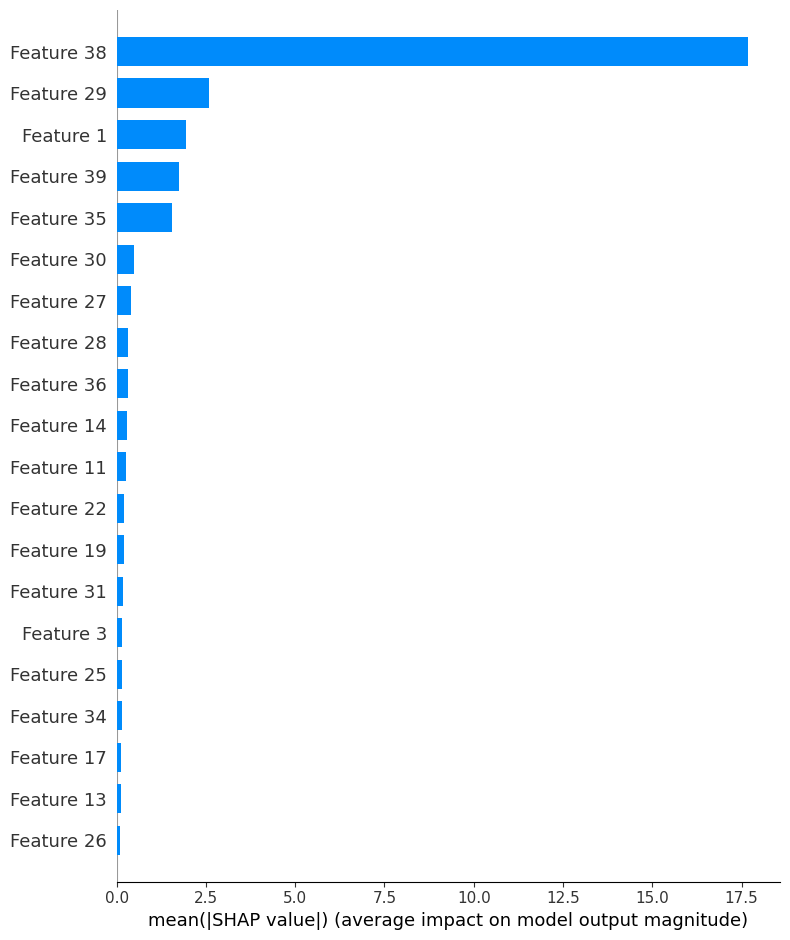

In [ ]:
# Extract fitted components
preproc = xgb.named_steps["pre"]
model   = xgb.named_steps["model"]

# Transform X_test into encoded numeric array for SHAP
X_test_trans = preproc.transform(X_test)

# Take a manageable sample for speed
sample_idx = np.random.RandomState(42).choice(
    X_test_trans.shape[0],
    size=min(800, X_test_trans.shape[0]),
    replace=False
)
X_sample = X_test_trans[sample_idx]

# Build SHAP explainer
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X_sample)

# Summary bar plot (which features matter most overall)
shap.summary_plot(shap_values, X_sample, plot_type="bar")

# **12. Business Insights & Recommendations**

Now, I will generate a ranked table of top predicted crime risers by NEIGHBOURHOOD × TYPE × SEASON, based on the XGBoost model. Then, I’ll format the results into plain-English sentences so the findings can be used directly in a report or presentation.

In [ ]:
# ---- Top predicted risers (already computed as top_risers in Step 10) ----
print("Top Predicted Rises in Crime (next season vs last):")
display(top_risers)

# ---- Convert to plain-English insights ----
insights = [
    f"In {row.NEIGHBOURHOOD}, {row.TYPE} is expected to rise by {row.delta_vs_last} incidents in {row.SEASON} "
    f"(predicted {row.pred_xgb}, last season {row.LAG1})."
    for row in top_risers.itertuples(index=False)
]

# Show first 5 insights
print("\nSample Insights:")
for s in insights[:5]:
    print("•", s)

Top Predicted Rises in Crime (next season vs last):


NEIGHBOURHOOD                                               TYPE  \
0              Musqueam                                        Other Theft   
1              Fairview                  Break and Enter Residential/Other   
2              Fairview                                   Theft of Vehicle   
3       West Point Grey                                        Other Theft   
4              Fairview  Vehicle Collision or Pedestrian Struck (with F...   
5         Arbutus Ridge                                        Other Theft   
6   Renfrew-Collingwood                                   Theft of Bicycle   
7              Fairview                                           Homicide   
8              Oakridge                                        Other Theft   
9          Stanley Park                                           Mischief   
10     Hastings-Sunrise                                   Theft of Bicycle   
11          Shaughnessy                  Break and Enter Residential/Other   
12  Renfrew-Collingwood                                           Homicide   
13             West End                                   Theft of Bicycle   
14      West Point Grey  Vehicle Collision or Pedestrian Struck (with I...   

    SEASON  LAG1   pred_xgb  delta_vs_last  
0   Summer   1.0  11.900000           10.9  
1   Summer   4.0   9.100000            5.1  
2   Summer   1.0   5.900000            4.9  
3   Summer  13.0  16.700001            3.7  
4   Summer   1.0   4.500000            3.5  
5   Winter  10.0  13.300000            3.3  
6   Summer   4.0   7.100000            3.1  
7   Summer   0.0   2.900000            2.9  
8   Winter  14.0  15.900000            1.9  
9   Winter   1.0   2.800000            1.8  
10  Summer   7.0   8.600000            1.6  
11  Winter   3.0   4.600000            1.6  
12  Summer   0.0   1.500000            1.5  
13  Summer  25.0  26.400000            1.4  
14  Winter   3.0   4.100000            1.1


Sample Insights:
• In Musqueam, Other Theft is expected to rise by 10.9 incidents in Summer (predicted 11.899999618530273, last season 1.0).
• In Fairview, Break and Enter Residential/Other is expected to rise by 5.1 incidents in Summer (predicted 9.100000381469727, last season 4.0).
• In Fairview, Theft of Vehicle is expected to rise by 4.9 incidents in Summer (predicted 5.900000095367432, last season 1.0).
• In West Point Grey, Other Theft is expected to rise by 3.7 incidents in Summer (predicted 16.700000762939453, last season 13.0).
• In Fairview, Vehicle Collision or Pedestrian Struck (with Fatality) is expected to rise by 3.5 incidents in Summer (predicted 4.5, last season 1.0).


# **13. Limitations, Ethics & Privacy Notes**


**Privacy Offsets:**
The Vancouver Police Department deliberately randomizes or offsets locations and times for sensitive incidents (e.g., Offence Against a Person). Clusters indicate general areas, not precise addresses.

**Coverage Bias:**
The dataset reflects founded incidents included in VPD Open Data, and may exclude categories for privacy or investigative reasons. It does not represent all calls or complaints.

**Comparability:**
VPD Open Data is not directly comparable to Statistics Canada crime stats. VPD uses “all offences” reporting, while StatsCan reports only the “most serious offence.”

**Temporal Scope:**
This analysis only used 2025 data. Predictive performance will improve with historical data (2003–2024).

**Ethical Use:**
Predictions should guide community safety planning and resource allocation, not profiling individuals or communities.


# **14. Save Artifacts (for GitHub/Report)**

Exporting the key outputs of the project so they can be included in GitHub repo or report. Specifically:

**season_type_matrix.csv** → crime type counts by season (from EDA).

**top_predicted_risers.csv** → table of neighbourhood/type seasonal increases (from prediction).

**crime_hotspots_map.html** → interactive hotspot map (from clustering).

In [ ]:
# ---- Create output folder ----
OUT_DIR = "/content/outputs"
os.makedirs(OUT_DIR, exist_ok=True)

# ---- Save EDA table: season × type ----
season_type.to_csv(f"{OUT_DIR}/season_type_matrix.csv")

# ---- Save prediction results ----
top_risers.to_csv(f"{OUT_DIR}/top_predicted_risers.csv", index=False)

# ---- Save Folium map ----
try:
    m.save(f"{OUT_DIR}/crime_hotspots_map.html")
    print("Saved map to:", f"{OUT_DIR}/crime_hotspots_map.html")
except Exception as e:
    print("Map not defined. Please re-run Step 9 before saving.")

print("All artifacts saved inside:", OUT_DIR)

Saved map to: /content/outputs/crime_hotspots_map.html
All artifacts saved inside: /content/outputs
